https://docs.llamaindex.ai/en/stable/examples/multi_modal/structured_image_retrieval/

In [1]:
!pip install llama-index-multi-modal-llms-gemini
!pip install llama-index-vector-stores-qdrant
!pip install llama-index-embeddings-gemini
!pip install llama-index-llms-gemini

In [2]:
!pip install "llama-index" "google-generativeai>=0.3.0" matplotlib qdrant_client



In [3]:
import os
import google.generativeai as genai

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"]  = GOOGLE_API_KEY

genai.configure(api_key=GOOGLE_API_KEY)

c:\Users\Ai\anaconda3\envs\conda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

from pathlib import Path
import random
from typing import Optional 

In [5]:
dir_path = 'src/input/Images/SROIE2019/train/img'
dir_path

'src/input/Images/SROIE2019/train/img'

In [6]:

def get_image_files(dir_path, sample: Optional[int] = 10, shuffle: bool = False):
    dir_path = Path(dir_path)
    image_paths = []
    for image_path in dir_path.glob("*.jpg"):
        image_paths.append(image_path)

    random.shuffle(image_paths)
    if sample:
        return image_paths[:sample]
    else:
        return image_paths

In [7]:
image_files = get_image_files(dir_path, sample=20)

In [8]:
image_files

[WindowsPath('src/input/Images/SROIE2019/train/img/X51008142062.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51006620189.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51006387812.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51005749905.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51008142068.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51005587254.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51007846388.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51008099041.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51006329399.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51007339167.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51006387847.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51005719882.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51008123476.jpg'),
 WindowsPath('src/input/Images/SROIE2019/train/img/X51005444033.jpg'),
 Windo

In [9]:


from pydantic import BaseModel, Field


class ReceiptInfo(BaseModel):
    company: str = Field(..., description="Company name")
    date: str = Field(..., description="Date field in DD/MM/YYYY format")
    address: str = Field(..., description="Address")
    total: float = Field(..., description="total amount")
    currency: str = Field(
        ..., description="Currency of the country (in abbreviations)"
    )
    summary: str = Field(
        ...,
        description="Extracted text summary of the receipt, including items purchased, the type of store, the location, and any other notable salient features (what does the purchase seem to be for?).",
    )




from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser





prompt_template_str = """\
    Can you summarize the image and return a response \
    with the following JSON format: \
"""


async def pydantic_gemini(output_class, image_documents, prompt_template_str):
    gemini_llm = GeminiMultiModal(api_key=GOOGLE_API_KEY, model_name="models/gemini-1.5-flash")

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = await llm_program.acall()
    return response


from llama_index.core import SimpleDirectoryReader
from llama_index.core.async_utils import run_jobs


async def aprocess_image_file(image_file):
    # should load one file
    print(f"Image file: {image_file}")
    img_docs = SimpleDirectoryReader(input_files=[image_file]).load_data()
    output = await pydantic_gemini(ReceiptInfo, img_docs, prompt_template_str)
    return output


async def aprocess_image_files(image_files):
    """Process metadata on image files."""

    new_docs = []
    tasks = []
    for image_file in image_files:
        task = aprocess_image_file(image_file)
        tasks.append(task)

    outputs = await run_jobs(tasks, show_progress=True, workers=5)
    return outputs

In [10]:
outputs = await aprocess_image_files(image_files)

  0%|          | 0/20 [00:00<?, ?it/s]

Image file: src\input\Images\SROIE2019\train\img\X51006387847.jpg


C:\Users\Ai\AppData\Local\Temp\ipykernel_26532\2794105779.py:35: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  gemini_llm = GeminiMultiModal(api_key=GOOGLE_API_KEY, model_name="models/gemini-1.5-flash")


Image file: src\input\Images\SROIE2019\train\img\X51005719882.jpg
Image file: src\input\Images\SROIE2019\train\img\X51008123476.jpg
Image file: src\input\Images\SROIE2019\train\img\X51005444033.jpg
Image file: src\input\Images\SROIE2019\train\img\X51007339112.jpg
> Raw output: ```json
{
  "company": "SANYU STATIONERY SHOP",
  "date": "24/05/2017",
  "address": "NO. 31GSS33G, JALAN SETIA INDAH 7,UJ13/X NO.170 SETIA ALAM",
  "total": 5.80,
  "currency": "RM",
  "summary": "Tax invoice from SANYU STATIONERY SHOP for a restaurant order chit.  Two items at 2.90 each totaling 5.80 RM.  The receipt also notes that goods sold are not returnable or refundable and encourages the customer to return."
}
```

Image file: src\input\Images\SROIE2019\train\img\X51005568884.jpg


  5%|▌         | 1/20 [00:14<04:34, 14.43s/it]

> Raw output: ```json
{
  "company": "Dion Realities Sdn Bhd",
  "date": "25/06/2018",
  "address": "Menara Dion #02-03, Level 2,\n27, Jalan Sultan Ismail,\n50250 Kuala Lumpur.",
  "total": 5.00,
  "currency": "RM",
  "summary": "This is a tax invoice for parking. The invoice number is 4953/0602/00602.  The parking ticket number is 010100. The parking fee was 5.00 RM for a stay of 0 Days, 0 Hr, 15 Min. The total amount accepted is 10.00 RM, with 5.00 RM change given.  The purchase appears to be for parking at Menara Dion."
}
```

> Raw output: ```json
{
  "company": "99 Speed Mart S/B",
  "date": "17-02-18",
  "address": "LOT P. T. 2811, JALAN ANGSA,\nTAMAN BERKELEY,\n41150 KLANG, SELANGOR\n1181-TN SRI SINAR\nGST ID. NO : 000181747712",
  "total": 213.00,
  "currency": "RM",
  "summary": "Receipt from 99 Speed Mart S/B in Klang, Selangor, Malaysia.  The purchase includes 483 Carlsberg cans (4% & 320ml) and 2101 Carlsberg Smooth Draught. The total cost was RM 213.00, paid in cash.  The 

 10%|█         | 2/20 [00:21<02:59,  9.98s/it]

> Raw output: ```json
{
  "company": "MR. D.I.Y. SDN BHD",
  "date": "24/11/2017",
  "address": "LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (CSI ID No :00109286528) (CHERAS LEISURE MALL)",
  "total": 3.90,
  "currency": "RM",
  "summary": "This is a receipt from MR. D.I.Y. SDN BHD for the purchase of 4 AAA batteries. The total cost was RM 3.90, including GST. The purchase was made on November 24, 2017 at 13:11.  The receipt indicates that exchanges are allowed within 7 days with the receipt, but no cash refunds are given."
}
```

Image file: src\input\Images\SROIE2019\train\img\X51006620189.jpg


 30%|███       | 6/20 [00:22<00:36,  2.61s/it]

> Raw output: ```json
{
  "company": "CNE ONE THREE SEAFOOD RESTAURANT SDN BHD",
  "date": "23/06/2018",
  "address": "NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.",
  "total": 179.50,
  "currency": "SR",
  "summary": "Receipt from CNE ONE THREE SEAFOOD RESTAURANT SDN BHD in Dengkil, Selangor, Malaysia.  The receipt details a meal including Yam Item, Soup Item (XL), Fish Item, Omelette Item, White Rice, Vege Item (M), and Beverage. The total cost was 179.50 SR."
}
```

Image file: src\input\Images\SROIE2019\train\img\X51006387812.jpg


 35%|███▌      | 7/20 [00:27<00:39,  3.02s/it]

> Raw output: ```json
{
  "company": "Yam Fresh",
  "date": "31/07/2016",
  "address": "No. 145G, Jalan Rimbunan Raya 1, Laman Rimbunan Kepong, 52100 Kuala Lumpur",
  "total": 8.35,
  "currency": "RM",
  "summary": "Dine-in receipt from Yam Fresh in Kuala Lumpur, Malaysia.  One Yam Fresh Signature-C (presumably a food item) was purchased for RM7.90.  6% GST and rounding adjustments are included in the final total of RM8.35.  The customer paid with RM10.50 cash and received RM2.15 in change."
}
```

> Raw output: ```json
{
  "company": "KEDAI PAPAN YEW CHUAN",
  "date": "02/05/2018",
  "address": "LOT 276(JALAN BANTING, 43800 DENGKIL, SELANGOR.",
  "total": 361.46,
  "currency": "RM",
  "summary": "Tax invoice from KEDAI PAPAN YEW CHUAN in Dengkil, Selangor, Malaysia for building materials.  The purchase includes 1,200 of item 100211 (BATU SIMEN 101870) at RM 0.23 each and 1 of item 101870 (PASIR HALUS) at RM 65.00. The total before tax is RM 341.00, with a total GST of RM 20.46. The to

 40%|████      | 8/20 [00:32<00:41,  3.50s/it]

> Raw output: ```json
{
  "company": "99 Speed Mart S/B",
  "date": "11-05-16",
  "address": "Lot R, 3398, Batu 4, Jalan Kapar, 42100 Klang, Selangor 1605-TMN SRI BINTANG GST ID: No 00018174712",
  "total": 177.20,
  "currency": "RM",
  "summary": "This receipt is from 99 Speed Mart S/B in Klang, Selangor, Malaysia.  The purchase includes various grocery items such as Anchor Serbuk Cuci, Dove Cream, full cream milk,  Lee Kum Kee Sos Tiram, potato chips,  Margarine,  Teh Tarik, Nutella Ferrero Hazel, and cheese chicken. The total amount is RM 177.20."
}
```

> Raw output: ```json
{
  "company": "TIMES BOOKSTORE",
  "date": "23/04/2017",
  "address": "LOT F21 & 22, CITTA MALL JAYA, PJ 19/4",
  "total": 37.65,
  "currency": "RM",
  "summary": "Purchase of stationery items from Times Bookstore in Citta Mall, Jaya, PJ 19/4. Items include: PILOT BP-1PT Ball Point Pen, PILOT FUDE MAKASE Brush Pen, PILOT M Pencil. Total quantity of items purchased is 3. The receipt also indicates that goods so

 55%|█████▌    | 11/20 [00:36<00:20,  2.32s/it]

> Raw output: ```json
{
  "company": "ENW Hardware Centre (M) Sdn. Bhd.",
  "date": "10/03/2018",
  "address": "No. G3, Blk G, Jln PJU 1A/3,\nAra Damansara, 47301\nPetaling Jaya, Selangor Darul Ehsan.",
  "total": 34.00,
  "currency": "RM",
  "summary": "Cash sale receipt from ENW Hardware Centre (M) Sdn. Bhd. in Petaling Jaya, Selangor. Items purchased include Wood Lacquer Thinner, Ufix Putty Filler, and Sand Paper Roll. The total amount is RM 34.00, including GST of RM 1.93."
}
```

Image file: src\input\Images\SROIE2019\train\img\X51008099041.jpg


 65%|██████▌   | 13/20 [00:39<00:14,  2.06s/it]

> Raw output: ```json
{
  "company": "KEDAI PAPAN YEW CHUAN",
  "date": "11/05/2018",
  "address": "LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR",
  "total": 68.90,
  "currency": "RM",
  "summary": "This is a receipt from Kedai Papan Yew Chuan in Dengkil, Selangor, Malaysia.  The receipt is for Suci Alam Jaya Transport and includes one item: PASIR HALUS (D), with a quantity of 1 and a price of 68.90 RM. The total amount is 68.90 RM, paid in cash. The GST is 3.90 RM."
}
```

> Raw output: ```json
{
  "company": "AEON CO. (M) BHD",
  "date": "20/02/2016",
  "address": "3RD FLR, AEON TAMAN MALURI SC, JALAN TUN RAZAK, 55100 KUALA LUMPUR CHERAS, 55100 KUALA LUMPUR",
  "total": 75.00,
  "currency": "MYR",
  "summary": "This is a receipt from AEON CO. (M) BHD located at 3rd FLR, AEON Taman Maluri SC, Jalan Tun Razak, 55100 Kuala Lumpur, Cheras. The total amount is 75.00 MYR.  The receipt shows a subtotal of 75.00, total sales including GST of 75.00, and a total after any change of 100.00.  T

 70%|███████   | 14/20 [00:42<00:13,  2.31s/it]

> Raw output: ```json
{
  "company": "TRI SHAAS SDN BHD (728515-M) MYDIN MART SRI MUDA",
  "date": "13/03/2017",
  "address": "4-20, Jalan Ria 25/62, Taman Sri Muda Seksyen 25, 40400 Shah Alam Selangor Tel : 03-51214970 Fax : 03-51218059 GST ID: 000429166592",
  "total": 5.00,
  "currency": "RM",
  "summary": "Purchase of 3 EVEREADY BAT H/D 1015 SW4 AA batteries at RM 2.50 each, totaling RM 5.00 before tax.  The receipt is from Mydin Mart Sri Muda in Shah Alam, Selangor, Malaysia.  The purchase appears to be for household batteries."
}
```

> Raw output: ```json
{
  "company": "UNIHAKKA INTERNATIONAL SDN BHD",
  "date": "12/06/2018",
  "address": "12, Jalan Tampin 74,Kawasan Perindustrian Taman Perindustrian, Nilai, Negeri Sembilan",
  "total": 20.20,
  "currency": "RM",
  "summary": "This is a receipt from Unihakka International Sdn Bhd for a purchase of RM 1.50 for '1 Meat 3 Vege' and RM1.00 for '1 Imported Vege'.  The total, including GST and rounding, was RM 20.20. The payment meth

 90%|█████████ | 18/20 [00:43<00:02,  1.25s/it]

> Raw output: ```json
{
  "company": "RESTORAN WAN SHENG",
  "date": "30-06-2018",
  "address": "No.2, Jalan Temenggung 19/9, Seksyen 9, Bandar Mahkota Cheras, 43200 Cheras, Selangor",
  "total": 4.20,
  "currency": "ZRL",
  "summary": "Tax invoice from Restoran Wan Sheng in Cheras, Selangor, Malaysia.  The purchase includes one Coke and one Soya Bean, totaling 4.20 ZRL.  The GST is 0%."
}
```



 95%|█████████▌| 19/20 [00:46<00:01,  1.52s/it]

> Raw output: ```json
{
  "company": "MIVE9 PHARMACY SDN BHD",
  "date": "31/03/2017",
  "address": "69, TALAN NOVA, USJ, SUBANG BB",
  "total": 12.15,
  "currency": "RM",
  "summary": "This is a receipt from MIVE9 Pharmacy Sdn Bhd located at 69, Talan Nova, USJ, Subang BB. The receipt is dated March 31, 2017.  Two items were purchased: Hurrix 2550606031171 (4.90 RM) and Hurrix 9655060603152 (6.60 RM). The total amount is 12.15 RM. The receipt includes GST details and a GST summary."
}
```



100%|██████████| 20/20 [00:47<00:00,  2.39s/it]

> Raw output: ```json
{
  "company": "SANYU STATIONERY SHOP",
  "date": "11/12/2017",
  "address": "NO. 16833G, JALAN SETIA INDAH X, UI13/X, 40170 SHAH ALAM",
  "total": 7.00,
  "currency": "RM",
  "summary": "This is a tax invoice from Sanyu Stationery Shop in Shah Alam, Malaysia. The purchase includes 2 items of 3.5000 each, totaling 7.00 RM.  The receipt shows a GST of 0.40 RM. The purchase seems to be for 2 units of SB-5882 CAMIS NCR BILL BOOK. The receipt also includes a request to keep the receipt for product warranty purposes."
}
```



In [11]:
from llama_index.core.schema import TextNode
from typing import List


def get_nodes_from_objs(
    objs: List[ReceiptInfo], image_files: List[str]
) -> TextNode:
    """Get nodes from objects."""
    nodes = []
    for image_file, obj in zip(image_files, objs):
        node = TextNode(
            text=obj.summary,
            metadata={
                "company": obj.company,
                "date": obj.date,
                "address": obj.address,
                "total": obj.total,
                "currency": obj.currency,
                "image_file": str(image_file),
            },
            excluded_embed_metadata_keys=["image_file"],
            excluded_llm_metadata_keys=["image_file"],
        )
        nodes.append(node)
    return nodes

In [12]:
nodes = get_nodes_from_objs(outputs, image_files)

In [13]:
print(nodes[0].get_content(metadata_mode="all"))

company: KEDAI PAPAN YEW CHUAN
date: 02/05/2018
address: LOT 276(JALAN BANTING, 43800 DENGKIL, SELANGOR.
total: 361.46
currency: RM
image_file: src\input\Images\SROIE2019\train\img\X51008142062.jpg

Tax invoice from KEDAI PAPAN YEW CHUAN in Dengkil, Selangor, Malaysia for building materials.  The purchase includes 1,200 of item 100211 (BATU SIMEN 101870) at RM 0.23 each and 1 of item 101870 (PASIR HALUS) at RM 65.00. The total before tax is RM 341.00, with a total GST of RM 20.46. The total amount due is RM 361.46. The bill is for SUCI ALAM JAYA TRANSPORT.


In [14]:
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# global settings
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

C:\Users\Ai\AppData\Local\Temp\ipykernel_26532\2879133722.py:15: DeprecationWarning: Call to deprecated class GeminiEmbedding. (Should use `llama-index-embeddings-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/embeddings/google_genai/)
  Settings.embed_model = GeminiEmbedding(
C:\Users\Ai\AppData\Local\Temp\ipykernel_26532\2879133722.py:18: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  Settings.llm = Gemini(api_key=GOOGLE_API_KEY)


#### Define Auto-Retriever


Define Auto-Retriever
Now we can setup our auto-retriever, which can perform semi-structured queries: structured queries through inferring metadata filters, along with semantic search.

We setup our schema definition capturing the receipt info which is fed into the prompt.

In [15]:
from llama_index.core.vector_stores import MetadataInfo, VectorStoreInfo


vector_store_info = VectorStoreInfo(
    content_info="Receipts",
    metadata_info=[
        MetadataInfo(
            name="company",
            description="The name of the store",
            type="string",
        ),
        MetadataInfo(
            name="address",
            description="The address of the store",
            type="string",
        ),
        MetadataInfo(
            name="date",
            description="The date of the purchase (in DD/MM/YYYY format)",
            type="string",
        ),
        MetadataInfo(
            name="total",
            description="The final amount",
            type="float",
        ),
        MetadataInfo(
            name="currency",
            description="The currency of the country the purchase was made (abbreviation)",
            type="string",
        ),
    ],
)

In [16]:
from llama_index.core.retrievers import VectorIndexAutoRetriever

retriever = VectorIndexAutoRetriever(
    index,
    vector_store_info=vector_store_info,
    similarity_top_k=2,
    empty_query_top_k=10,  # if only metadata filters are specified, this is the limit
    verbose=True,
)

In [17]:
# from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import Image


def display_response(nodes: List[TextNode]):
    """Display response."""
    for node in nodes:
        print(node.get_content(metadata_mode="all"))
        # img = Image.open(open(node.metadata["image_file"], 'rb'))
        display(Image(filename=node.metadata["image_file"], width=200))

# Run Some Queries

In [18]:
nodes

[TextNode(id_='d81e40e8-1b43-4568-938e-d534b176c0b8', embedding=None, metadata={'company': 'KEDAI PAPAN YEW CHUAN', 'date': '02/05/2018', 'address': 'LOT 276(JALAN BANTING, 43800 DENGKIL, SELANGOR.', 'total': 361.46, 'currency': 'RM', 'image_file': 'src\\input\\Images\\SROIE2019\\train\\img\\X51008142062.jpg'}, excluded_embed_metadata_keys=['image_file'], excluded_llm_metadata_keys=['image_file'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text='Tax invoice from KEDAI PAPAN YEW CHUAN in Dengkil, Selangor, Malaysia for building materials.  The purchase includes 1,200 of item 100211 (BATU SIMEN 101870) at RM 0.23 each and 1 of item 101870 (PASIR HALUS) at RM 65.00. The total before tax is RM 341.00, with a total GST of RM 20.46. The total amount due is RM 361.46. The bill is for SUCI ALAM JAYA TRANSPORT.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, metadata_seperator='\n', text_template='{metadata_str}\n\n{content}'),
 TextNode(id_=

Using query str: restaurant orders of noodles
Using filters: []
company: CNE ONE THREE SEAFOOD RESTAURANT SDN BHD
date: 23/06/2018
address: NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
total: 179.5
currency: SR
image_file: src\input\Images\SROIE2019\train\img\X51008164999.jpg

Receipt from CNE ONE THREE SEAFOOD RESTAURANT SDN BHD in Dengkil, Selangor, Malaysia.  The receipt details a meal including Yam Item, Soup Item (XL), Fish Item, Omelette Item, White Rice, Vege Item (M), and Beverage. The total cost was 179.50 SR.


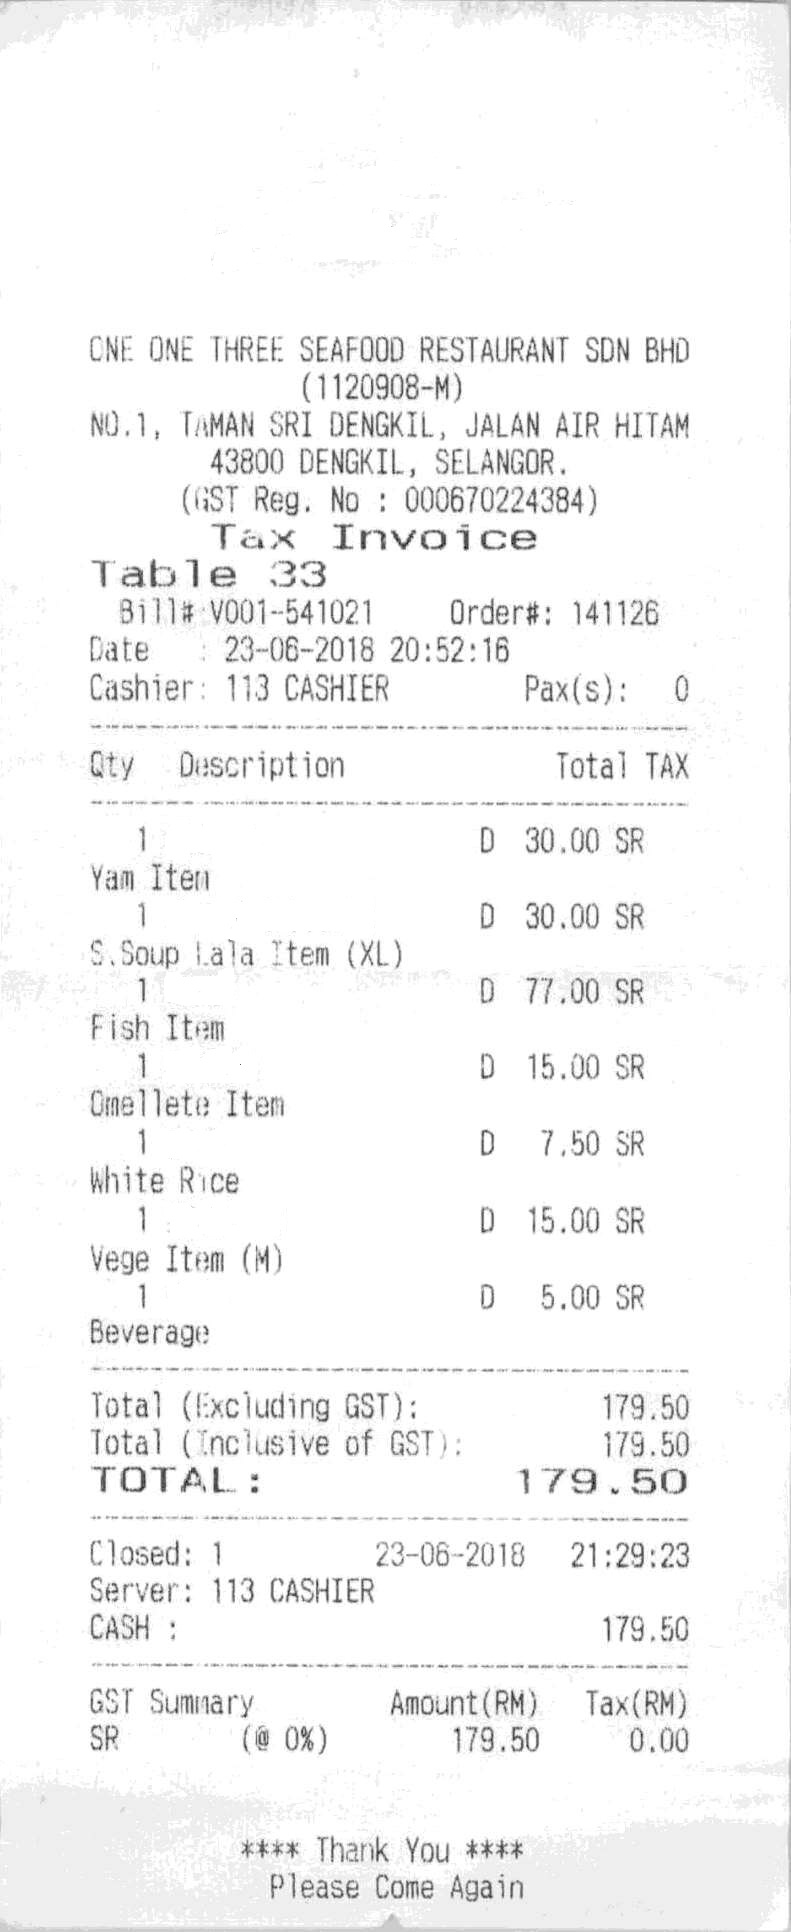

company: SANYU STATIONERY SHOP
date: 24/05/2017
address: NO. 31GSS33G, JALAN SETIA INDAH 7,UJ13/X NO.170 SETIA ALAM
total: 5.8
currency: RM
image_file: src\input\Images\SROIE2019\train\img\X51007339112.jpg

Tax invoice from SANYU STATIONERY SHOP for a restaurant order chit.  Two items at 2.90 each totaling 5.80 RM.  The receipt also notes that goods sold are not returnable or refundable and encourages the customer to return.


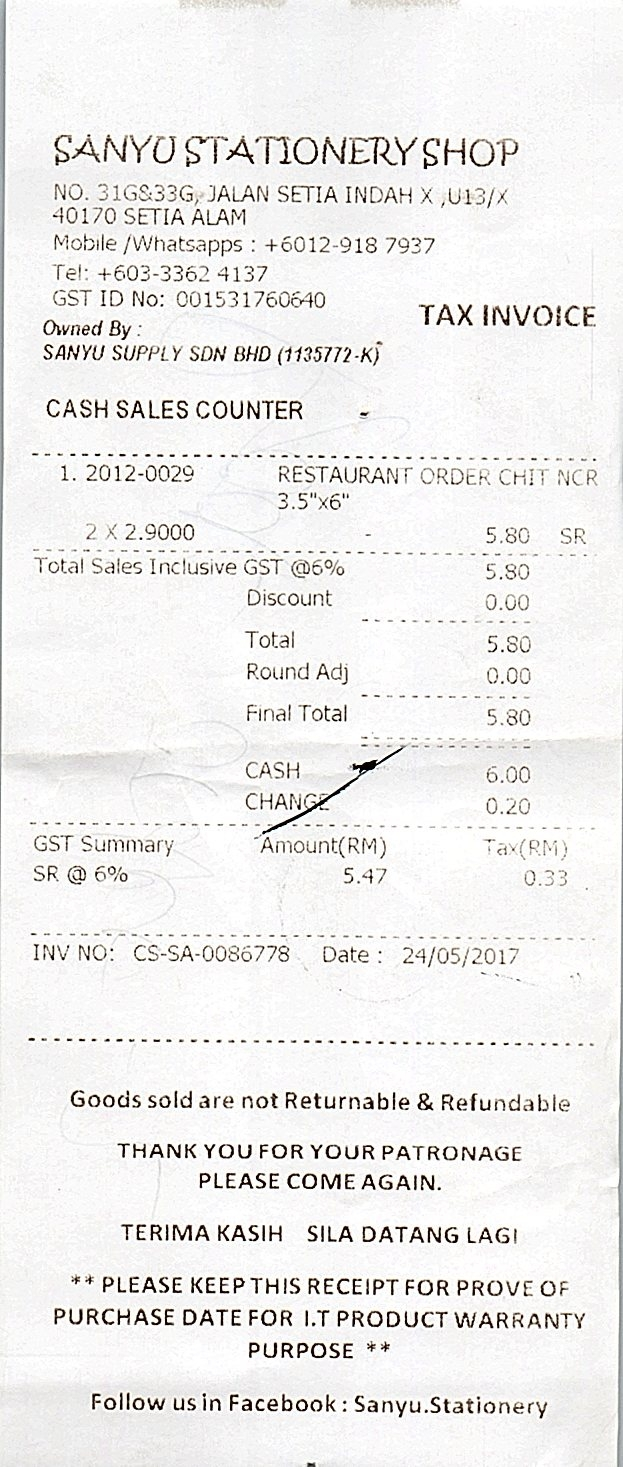

In [20]:
nodes = retriever.retrieve(
    "Tell me about some restaurant orders of noodles"
)
display_response(nodes)